In [226]:
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from typing import List
import random
import cv2
from sklearn.metrics import mean_squared_error
from skimage.util import random_noise
# %matplotlib inline

In [227]:
def get_image_scale(im: ndarray, c: int) -> ndarray:
    assert len(im.shape) == 3 and im.shape[-1] == 3
    return im[:,:,c]

def set_image_scale(im: ndarray, c: int, to: ndarray):
    assert len(im.shape) == 3 and im.shape[-1] == 3
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            im[i][j][c] = to[i][j]

def generate_noise(im: ndarray) -> ndarray:
    result: ndarray = MAX_COLOR_SCALE * np.ones(im.shape, dtype=im.dtype)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if random.random() > NOISE_PERCENTAGE:
                result[i][j] = im[i][j]
    return result
    # return random_noise(im, mode ='gaussian', mean=NOISE_PERCENTAGE)*255
def generate_noise_rgb(im: ndarray) -> ndarray:
    result: ndarray = np.zeros(im.shape, dtype=im.dtype)
    for i in range(3):
        set_image_scale(result, i, generate_noise(get_image_scale(im, i)))
    return result

def get_converted_image(im: ndarray) -> ndarray:
    assert len(im.shape) == 3 and im.shape[-1] == 3
    b, g, r = cv2.split(im)
    return cv2.merge([r, g, b])

def plt_show(im: ndarray) -> ndarray:
    plt.imshow(get_converted_image(im))
    plt.show()

In [228]:
def get_distribution(im: ndarray) -> ndarray:
    L: int = im.min().astype(int)
    R: int = im.max().astype(int)
    N: int = im.shape[0]
    M: int = im.shape[1]
    size: int = N * M

    color_freq: List = [0] * (R + 1)
    for i in range(N):
        for j in range(M):
            color_freq[int(im[i][j])] += 1
    
    p: ndarray = np.zeros(R+1, dtype=float)
    for i in range(L, R+1):
        if i > 0:
            color_freq[i] += color_freq[i - 1]
            p[i] = color_freq[i] / size

    assert abs(p[-1] - 1) < 1e-5
    return p
class GFilter:
    def __init__(self, im: ndarray, window_size: int, r: int, noise_threshold: float):
        self.im: ndarray = im
        self.window_size: int = window_size
        self.r: int = r
        self.noise_threshold: float = noise_threshold
    def gfilter(self,im: ndarray) -> ndarray:
        dist: ndarray = get_distribution(im)
        im = np.pad(im, ((self.window_size, self.window_size), (self.window_size, self.window_size)), 'edge')
        N: int = im.shape[0]
        M: int = im.shape[1]

        result: ndarray = np.zeros(im.shape, dtype=im.dtype)

        for i in range(self.window_size, N - self.window_size):
            for j in range(self.window_size, M - self.window_size):
                if (self.noise_threshold):
                    if dist[int(im[i][j])] > self.noise_threshold and dist[int(im[i][j])] < 1 - self.noise_threshold:
                        result[i][j] = im[i][j]
                        continue

                W1: List = []
                W2: List = []
                W3: List = []
                W4: List = []

                for k in range(-self.window_size, self.window_size+1):
                    if k == 0:
                        continue
                    W1.append(im[i][j + k])
                    W2.append(im[i + k][j + k])
                    W3.append(im[i + k][j])
                    W4.append(im[i - k][j + k])

                W1 = sorted(W1)
                W2 = sorted(W2)
                W3 = sorted(W3)
                W4 = sorted(W4)

                index: int = R - 1
                s1: float = max([W1[index], W2[index], W3[index], W4[index]])
                
                reversedIndex: int = 2 * self.window_size - self.r
                s2: float = max([W1[reversedIndex], W2[reversedIndex], W3[reversedIndex], W4[reversedIndex]])
                result[i][j] = sorted([s1, s2, im[i][j]])[1]

        return result[self.window_size: -self.window_size, self.window_size: -self.window_size]

    def gfilter_rgb(self) -> ndarray:
        im = self.im
        assert len(im.shape) == 3 and im.shape[-1] == 3
        result: ndarray = np.zeros(im.shape, dtype=im.dtype)
        for i in range(3):
            set_image_scale(result, i, self.gfilter(get_image_scale(im, i)))
        return result

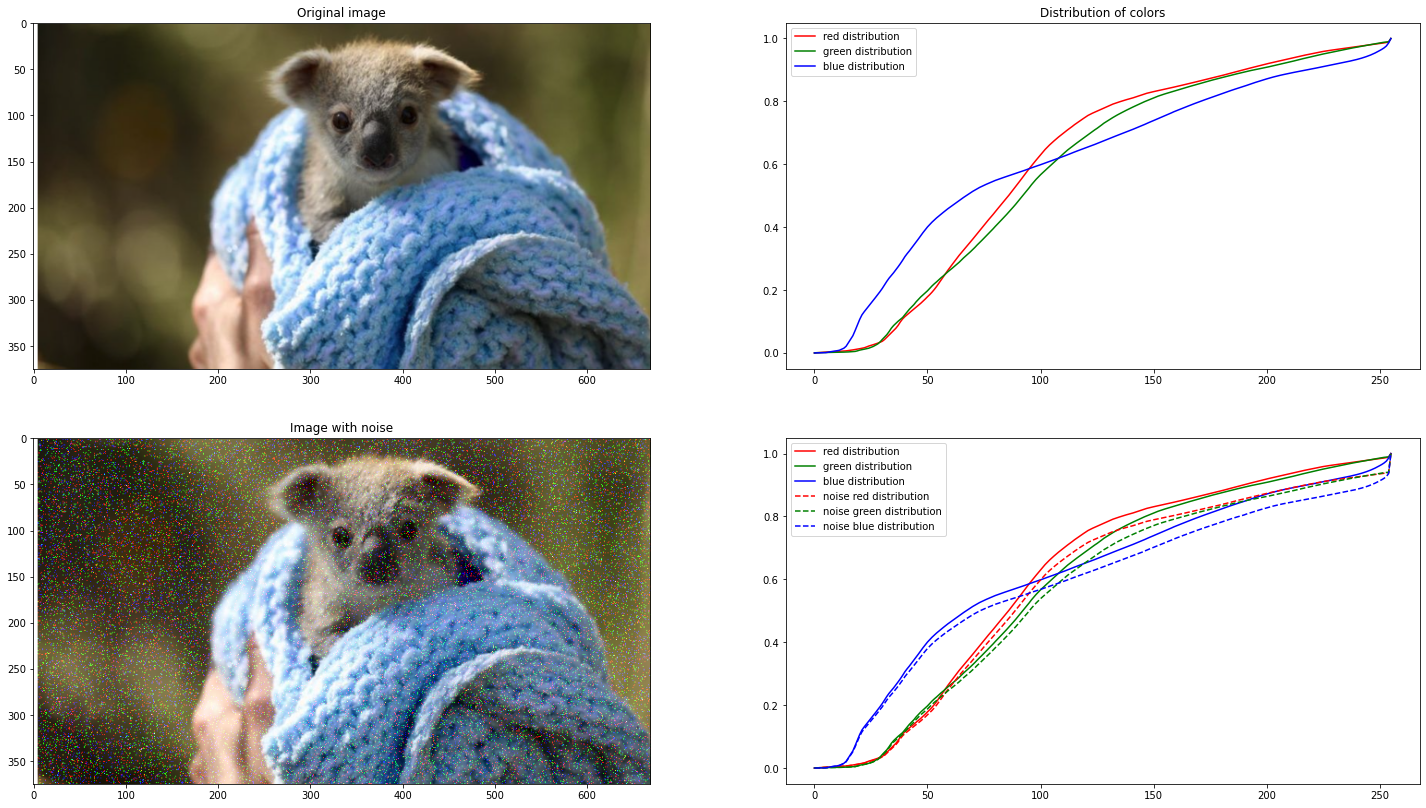

In [229]:
IMAGE_PATH = "images/koala.png"
IMAGE_NAME = IMAGE_PATH.split('.')[-2]
MAX_COLOR_SCALE = 255
NOISE_PERCENTAGE = 0.05

im = cv2.cvtColor(cv2.imread(IMAGE_PATH), cv2.COLOR_BGR2RGB)
im_noise = generate_noise_rgb(im)
cv2.imwrite(f"{IMAGE_NAME}-with-noise.png", cv2.cvtColor(im_noise, cv2.COLOR_RGB2BGR))

fig, ax = plt.subplots(2, 2, figsize=(25, 14))
# plt.subplot(1, 2, 1)
ax[0][0].imshow(im)
ax[0][0].set_title('Original image')
# plt.title('Original image')
# plt.subplot(1, 2, 2)

ax[0][1].plot(get_distribution(im[:,:,0]),'r', label = 'red distribution')
ax[0][1].plot(get_distribution(im[:,:,1]),'g', label = 'green distribution')
ax[0][1].plot(get_distribution(im[:,:,2]),'b', label = 'blue distribution')
ax[0][1].legend()
ax[0][1].set_title('Distribution of colors')

ax[1][0].imshow(im_noise)
ax[1][0].set_title('Image with noise')

ax[1][1].plot(get_distribution(im[:,:,0]),'r', label = 'red distribution')
ax[1][1].plot(get_distribution(im[:,:,1]),'g', label = 'green distribution')
ax[1][1].plot(get_distribution(im[:,:,2]),'b', label = 'blue distribution')
ax[1][1].plot(get_distribution(im_noise[:,:,0]),'r--', label = 'noise red distribution')
ax[1][1].plot(get_distribution(im_noise[:,:,1]),'g--', label = 'noise green distribution')
ax[1][1].plot(get_distribution(im_noise[:,:,2]),'b--', label = 'noise blue distribution')
ax[1][1].legend()
plt.show()

Median filter RMSE: 0.0019622629268255705
Median filter RMSE: 0.003378963321249725
Median filter RMSE: 0.004841495821548561
Median filter RMSE: 0.0062894758881518855
Median filter RMSE: 0.007709723274084766


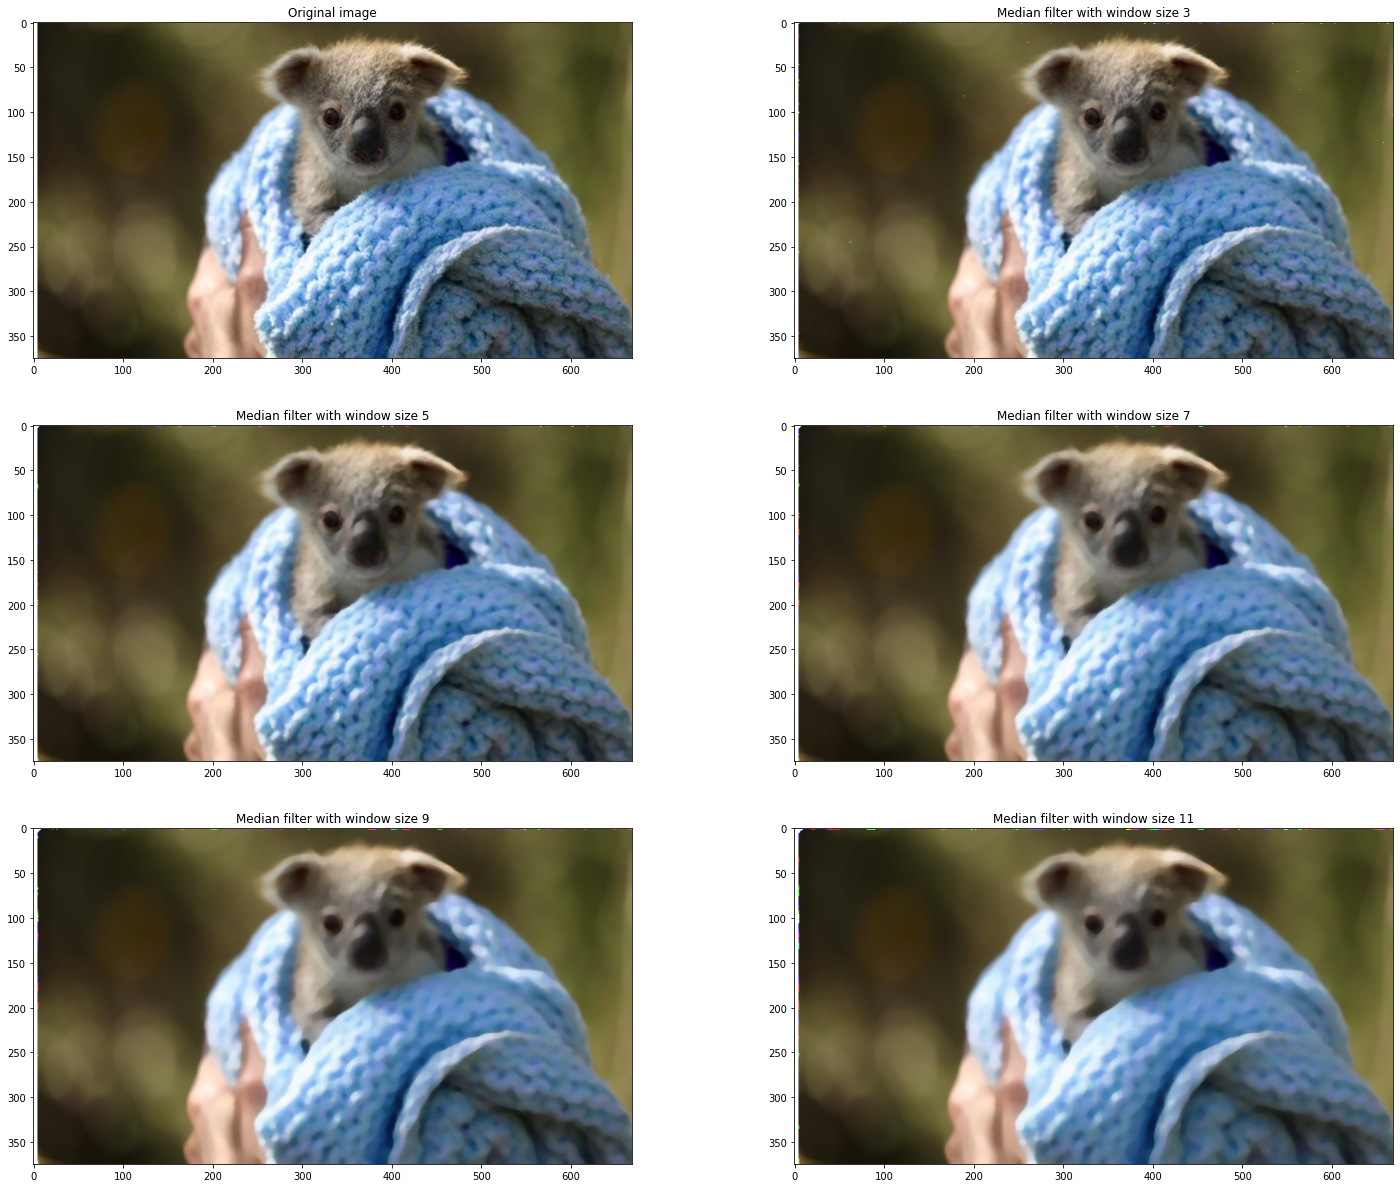

In [230]:
fix, ax = plt.subplots(3, 2, figsize=(25, 21))

ax[0][0].imshow(im)
ax[0][0].set_title('Original image')
for idx,window_size in enumerate([3, 5, 7, 9, 11]):

    med_filter = cv2.medianBlur(im_noise, window_size)
    rmse = 0
    for i, color in enumerate(['red', 'green', 'blue']):
        rmse += mean_squared_error(get_distribution(med_filter[:,:,i]), get_distribution(im[:,:,i]), squared=False)
    rmse /= 3
    print(f"Median filter RMSE: {rmse}")
    #plt increase size of image
    ax[int((idx+1)/2)][(idx+1)%2].imshow(med_filter)
    ax[int((idx+1)/2)][(idx+1)%2].set_title(f"Median filter with window size {window_size}")
plt.show()

In [231]:
# Experiment with different values of R, window_size and noise_threshold. Take long time to run
# rmse = 0
# for i, color in enumerate(['red', 'green', 'blue']):
#     rmse += mean_squared_error(get_distribution(im_noise[:,:,i]), get_distribution(im[:,:,i]), squared=False)
# rmse /= 3
# print(f"Noise RMSE: {rmse}")
# for WINDOW_SIDE in range(3,5):
#     for R in range(1,WINDOW_SIDE+1):
#         for NOISE_THRESHOLD in [None, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
#             gfilter = GFilter(im_noise, WINDOW_SIDE, R, NOISE_THRESHOLD)
#             im_gfilter = gfilter.gfilter_rgb()
#             rmse = 0
#             for i, color in enumerate(['red', 'green', 'blue']):
#                 rmse += mean_squared_error(get_distribution(im_gfilter[:,:,i]), get_distribution(im[:,:,i]), squared=False)
#             rmse /= 3
#             print(f"Window side: {WINDOW_SIDE}, R: {R}, Noise threshold: {NOISE_THRESHOLD}, RMSE: {rmse}")

Noise RMSE: 0.034338828479182244
Window side: 3, R: 1, Noise threshold: None, RMSE: 0.026849351034732308
Window side: 3, R: 1, Noise threshold: 0.01, RMSE: 0.025378839175973777
Window side: 3, R: 1, Noise threshold: 0.05, RMSE: 0.025389413906985403
Window side: 3, R: 1, Noise threshold: 0.1, RMSE: 0.02542778567840817
Window side: 3, R: 1, Noise threshold: 0.15, RMSE: 0.0255938123425464
Window side: 3, R: 1, Noise threshold: 0.2, RMSE: 0.025780637889464966
Window side: 3, R: 1, Noise threshold: 0.25, RMSE: 0.02598449708937775
Window side: 3, R: 1, Noise threshold: 0.3, RMSE: 0.026155717214039614
Window side: 3, R: 2, Noise threshold: None, RMSE: 0.012210541649175588
Window side: 3, R: 2, Noise threshold: 0.01, RMSE: 0.006885898669684067
Window side: 3, R: 2, Noise threshold: 0.05, RMSE: 0.0070052531023962715
Window side: 3, R: 2, Noise threshold: 0.1, RMSE: 0.0071831352607779385
Window side: 3, R: 2, Noise threshold: 0.15, RMSE: 0.007782486124325271
Window side: 3, R: 2, Noise threshold

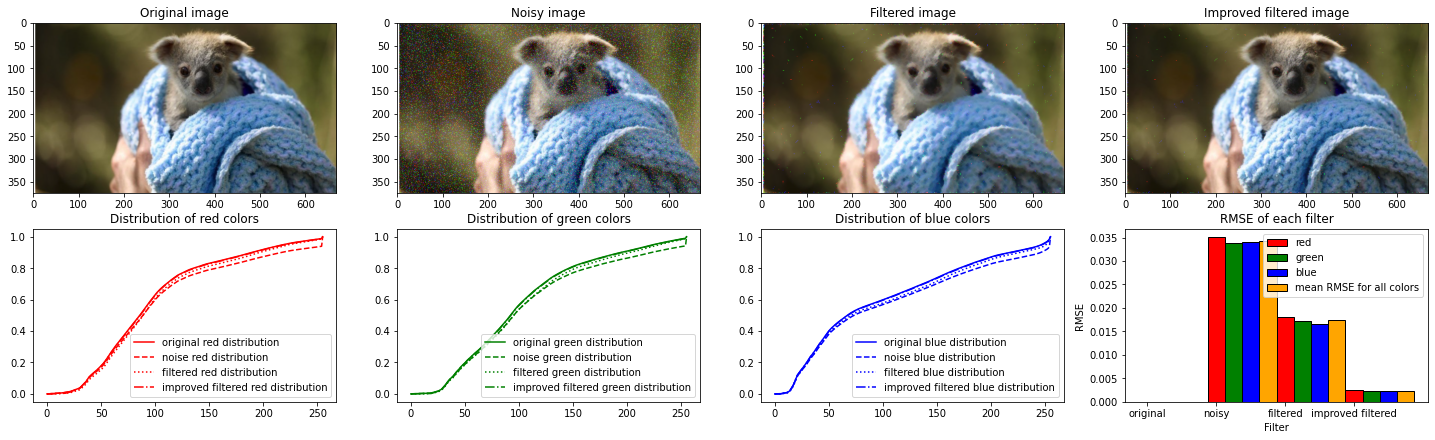

In [232]:
WINDOW_SIDE = 3
R = 3# gives the best result
NOISE_THRESHOLD = 0.01
gfilter = GFilter(im_noise, WINDOW_SIDE, R, None)
filtered_im = gfilter.gfilter_rgb()
# cv2.imwrite(f'{IMAGE_NAME}-filtered.improved.png', im)
# plt_show(cv2.cvtColor(filtered_im, cv2.COLOR_RGB2BGR))
gfilter = GFilter(im_noise, WINDOW_SIDE, R, NOISE_THRESHOLD)
filtered_im_improved = gfilter.gfilter_rgb()

cv2.imwrite(f'{IMAGE_NAME}-filtered.png', cv2.cvtColor(filtered_im, cv2.COLOR_RGB2BGR))
cv2.imwrite(f'{IMAGE_NAME}-filtered.improved.png', cv2.cvtColor(filtered_im_improved, cv2.COLOR_RGB2BGR))

fig, ax = plt.subplots(2, 4, figsize=(25, 7))
# plt.subplot(1, 2, 1)
ax[0][0].imshow(im)
ax[0][0].set_title('Original image')
ax[0][1].imshow(im_noise)
ax[0][1].set_title('Noisy image')
ax[0][2].imshow(filtered_im)
ax[0][2].set_title('Filtered image')
ax[0][3].imshow(filtered_im_improved)
ax[0][3].set_title('Improved filtered image')
ax[1][0].plot(get_distribution(im[:,:,0]),'r', label = 'original red distribution')
ax[1][0].plot(get_distribution(im_noise[:,:,0]),'r--', label = 'noise red distribution')
ax[1][0].plot(get_distribution(filtered_im[:,:,0]),'r:', label = 'filtered red distribution')
ax[1][0].plot(get_distribution(filtered_im_improved[:,:,0]),'r-.', label = 'improved filtered red distribution')
ax[1][0].legend()
ax[1][0].set_title('Distribution of red colors')
ax[1][1].plot(get_distribution(im[:,:,1]),'g', label = 'original green distribution')
ax[1][1].plot(get_distribution(im_noise[:,:,1]),'g--', label = 'noise green distribution')
ax[1][1].plot(get_distribution(filtered_im[:,:,1]),'g:', label = 'filtered green distribution')
ax[1][1].plot(get_distribution(filtered_im_improved[:,:,1]),'g-.', label = 'improved filtered green distribution')
ax[1][1].legend()
ax[1][1].set_title('Distribution of green colors')
ax[1][2].plot(get_distribution(im[:,:,2]),'b', label = 'original blue distribution')
ax[1][2].plot(get_distribution(im_noise[:,:,2]),'b--', label = 'noise blue distribution')
ax[1][2].plot(get_distribution(filtered_im[:,:,2]),'b:', label = 'filtered blue distribution')
ax[1][2].plot(get_distribution(filtered_im_improved[:,:,2]),'b-.', label = 'improved filtered blue distribution')
ax[1][2].legend()
ax[1][2].set_title('Distribution of blue colors')

rmses = list()
for j, image in enumerate([im, im_noise, filtered_im, filtered_im_improved]):
    rmses.append([])
    for i, color in enumerate(['red', 'green', 'blue']):
        rmse = mean_squared_error(get_distribution(image[:,:,i]), get_distribution(im[:,:,i]), squared=False)
        # print(f'RMSE for {color} in {["original", "noisy", "filtered", "improved filtered"][j]} image: {rmse}')
        rmses[j].append(rmse)
    rmses[j].append(sum(rmses[j])/3)
    # print(f'RMSE for all colors in {["original", "noisy", "filtered", "improved filtered"][j]} image: {rmses[j]}')

r = np.arange(4)
name = ['red', 'green', 'blue', 'mean RMSE for all colors']
for i, color in enumerate(['r', 'g', 'b', 'orange']):
    
    ax[1][3].bar(r + i/4, [rmses[j][i] for j in range(4)], width = 0.25, label = name[i], color = color, edgecolor = 'black')
plt.sca(ax[1, 3])
plt.xticks(range(4),['original', 'noisy', 'filtered', 'improved filtered'])
ax[1][3].set_xlabel("Filter")
ax[1][3].set_ylabel("RMSE")
ax[1][3].legend()
ax[1][3].set_title("RMSE of each filter")
  
# ax[1][3].grid(linestyle='--')
# ax[1][3].xticks(r + 0.25,["original", "noisy", "filtered", "improved filtered"])

# 
plt.show()


In [233]:
for i in range(4):
    print(f'RMSE for {["original", "noisy", "filtered", "improved filtered"][i]} image: {rmses[i][-1]}')

RMSE for original image: 0.0
RMSE for noisy image: 0.034338828479182244
RMSE for filtered image: 0.017366213397177196
RMSE for improved filtered image: 0.0023958154209508995


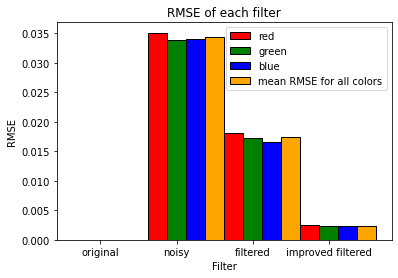

In [234]:
#create a list size of 3
rmses = list()
for j, image in enumerate([im, im_noise, filtered_im, filtered_im_improved]):
    rmses.append([])
    for i, color in enumerate(['red', 'green', 'blue']):
        rmse = mean_squared_error(get_distribution(image[:,:,i]), get_distribution(im[:,:,i]), squared=False)
        # print(f'RMSE for {color} in {["original", "noisy", "filtered", "improved filtered"][j]} image: {rmse}')
        rmses[j].append(rmse)
    rmses[j].append(sum(rmses[j])/3)
    # print(f'RMSE for all colors in {["original", "noisy", "filtered", "improved filtered"][j]} image: {rmses[j]}')

r = np.arange(4)
name = ['red', 'green', 'blue', 'mean RMSE for all colors']
for i, color in enumerate(['r', 'g', 'b', 'orange']):
    
    plt.bar(r + i/4, [rmses[j][i] for j in range(4)], width = 0.25, label = name[i], color = color, edgecolor = 'black')
plt.xticks(r + 0.25, ['original', 'noisy', 'filtered', 'improved filtered'])
plt.xlabel("Filter")
plt.ylabel("RMSE")
plt.title("RMSE of each filter")
  
# plt.grid(linestyle='--')
# plt.xticks(r + 0.25,["original", "noisy", "filtered", "improved filtered"])
plt.legend()
# 

In [235]:
#create a list size of 3
for i, color in enumerate(['red', 'green', 'blue']):
    for j, image in enumerate([im, im_noise, filtered_im, filtered_im_improved]):
        rmse = np.sqrt(np.mean((image[:,:,i].flatten() - im[:,:,i].flatten())**2))
        print(f'RMSE for {color} in {["original", "noisy", "filtered", "improved filtered"][j]} image: {rmse}')

RMSE for red in original image: 0.0
RMSE for red in noisy image: 2.3359617909523345
RMSE for red in filtered image: 4.791033395470356
RMSE for red in improved filtered image: 1.6762772238923696
RMSE for green in original image: 0.0
RMSE for green in noisy image: 2.322649038287382
RMSE for green in filtered image: 4.688944050946315
RMSE for green in improved filtered image: 1.559444920601122
RMSE for blue in original image: 0.0
RMSE for blue in noisy image: 2.327789270936139
RMSE for blue in filtered image: 4.699930561668356
RMSE for blue in improved filtered image: 1.4936810933962135


In [236]:

for j, image in enumerate([im, im_noise, filtered_im, filtered_im_improved]):
    print(image.shape)

(375, 669, 3)
(375, 669, 3)
(375, 669, 3)
(375, 669, 3)
